#Quanvolutional Neural Networks

##Classical convolution

The convolutional neural network (CNN) is a widely used model in classical machine learning, specifically designed for image processing. The fundamental concept behind this model involves the use of a convolution layer, where instead of globally processing the entire input data with a single function, a local convolution is applied.

In the case of image inputs, the CNN sequentially processes small local regions using the same kernel. The output obtained for each region is typically associated with different channels of a single output pixel. The aggregation of all the output pixels creates a new object resembling an image, which can then be further processed by additional layers.

##Quantum convolution

The concept of extending ideas to the context of quantum variational circuits can also be applied to the process of quantum convolution. This approach closely resembles a procedure used in a ref.[1].

Initially, a small portion of the input image, such as a 2x2 square, is integrated into a quantum circuit. In this demonstration, this integration is achieved through parametrized rotations applied to qubits that are initialized in the ground state.

Subsequently, a quantum computation, associated with a unitary U, is carried out on the system. This unitary may be generated by a variational quantum circuit or by a random circuit as proposed in the ref.[1].

Following the quantum computation, the quantum system is measured, resulting in a list of classical expectation values. While the measurement results could be post-processed classically, for the purpose of this demonstration, the raw expectation values are used directly.

Similar to a classical convolution layer, each expectation value is linked to a different channel of a single output pixel. By iterating this procedure over different regions, the full input image can be scanned, ultimately producing a multi-channel image as the output.

The quantum convolution can be succeeded by additional quantum layers or classical layers. The key distinction from a classical convolution lies in the fact that a quantum circuit can generate highly complex kernels whose computation could be considered classically intractable, at least in principle.

#Importing Libraries

In [ ]:
!pip install pennylane

This cell imports the necessary libraries for the quantum machine learning task. PennyLane is used for quantum computing, NumPy for numerical operations, TensorFlow for machine learning, and Matplotlib for plotting.

In [2]:
# Import necessary libraries
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

#Setting Hyperparameters

This cell sets the hyperparameters for the model and the random seeds for reproducibility. The number of epochs is reduced for faster execution in this example.

In [3]:
# Set hyperparameters
n_epochs = 10    # Number of optimization epochs (reduced for faster execution)
n_layers = 1     # Number of random layers in the quantum circuit
n_train = 50     # Size of the train dataset
n_test = 30      # Size of the test dataset

# Set random seeds for reproducibility
np.random.seed(0)
tf.random.set_seed(0)

#Loading and Preprocessing MNIST Dataset

This cell loads the MNIST dataset, a standard benchmark dataset for image classification, and preprocesses it by normalizing pixel values, reducing its size for faster execution, and adding an extra dimension for convolution channels.

In [4]:
# Load and preprocess the MNIST dataset
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values to be between 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add an extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


#Defining Quantum Device and Circuit

This cell defines the quantum device and the quantum circuit to be used for the convolution operation. The circuit encodes input data using Ry rotations, applies a random quantum layer, and measures the expectation values of PauliZ on each qubit.

In [5]:
# Define the quantum device and circuit
dev = qml.device("default.qubit", wires=4)  # Initialize a quantum device with 4 qubits
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))  # Random parameters for the quantum circuit

@qml.qnode(dev)
def circuit(phi):
    """Quantum circuit for convolution.

    Args:
        phi (array[float]): Input data to be encoded into the circuit.

    Returns:
        list[float]: Expectation values of PauliZ measurements on each qubit.
    """
    # Encode input data into the circuit using Ry rotations
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Apply a random quantum circuit (layer)
    RandomLayers(rand_params, wires=list(range(4)))

    # Measure the expectation values of PauliZ on each qubit
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

#Performing Quantum Convolution

This cell defines the quantum convolution operation. It processes the input image in 2x2 blocks, feeds each block to the quantum circuit, and stores the resulting expectation values in the corresponding output pixel, effectively downsampling the image.

In [6]:
def quanv(image):
    """Performs quantum convolution on an image.

    Args:
        image (array[float]): Input image.

    Returns:
        array[float]: Convolved output image.
    """
    out = np.zeros((14, 14, 4))  # Initialize output image

    # Loop over 2x2 squares in the input image
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Extract a 2x2 square from the image
            phi = [
                image[j, k, 0],
                image[j, k + 1, 0],
                image[j + 1, k, 0],
                image[j + 1, k + 1, 0]
            ]
            # Process the square with the quantum circuit
            q_results = circuit(phi)
            # Assign the results to the corresponding output pixel
            for c in range(4):
                out[j // 2, k// 2, c] = q_results[c]
    return out

#Quantum Preprocessing of Images

This cell applies the quantum convolution function quanv to preprocess both the training and test images, preparing them for further processing. This step effectively embeds quantum features into the image data.

In [7]:
# Preprocess the training and test images using quantum convolution
q_train_images = []
print("Quantum pre-processing of train images:")
for idx, img in enumerate(train_images):
    print("{}/{}        ".format(idx + 1, n_train),flush=True)
    q_train_images.append(quanv(img))
q_train_images = np.asarray(q_train_images)

q_test_images = []
print("\nQuantum pre-processing of test images:")
for idx, img in enumerate(test_images):
    print("{}/{}        ".format(idx + 1, n_test), flush=True)
    q_test_images.append(quanv(img))
q_test_images = np.asarray(q_test_images)

Quantum pre-processing of train images:
1/50        
2/50        
3/50        
4/50        
5/50        
6/50        
7/50        
8/50        
9/50        
10/50        
11/50        
12/50        
13/50        
14/50        
15/50        
16/50        
17/50        
18/50        
19/50        
20/50        
21/50        
22/50        
23/50        
24/50        
25/50        
26/50        
27/50        
28/50        
29/50        
30/50        
31/50        
32/50        
33/50        
34/50        
35/50        
36/50        
37/50        
38/50        
39/50        
40/50        
41/50        
42/50        
43/50        
44/50        
45/50        
46/50        
47/50        
48/50        
49/50        
50/50        

Quantum pre-processing of test images:
1/30        
2/30        
3/30        
4/30        
5/30        
6/30        
7/30        
8/30        
9/30        
10/30        
11/30        
12/30        
13/30        
14/30        
15/30        
16/30        
17/30        


#Visualizing Quantum Convolution Outputs

This cell aims to visualize the output of the quantum convolution layer for a few sample images from the training set.

This visualization is useful for understanding how the quantum convolution layer transforms the input images. By examining the output channels, we can gain insights into the features that the quantum circuit is learning to extract.

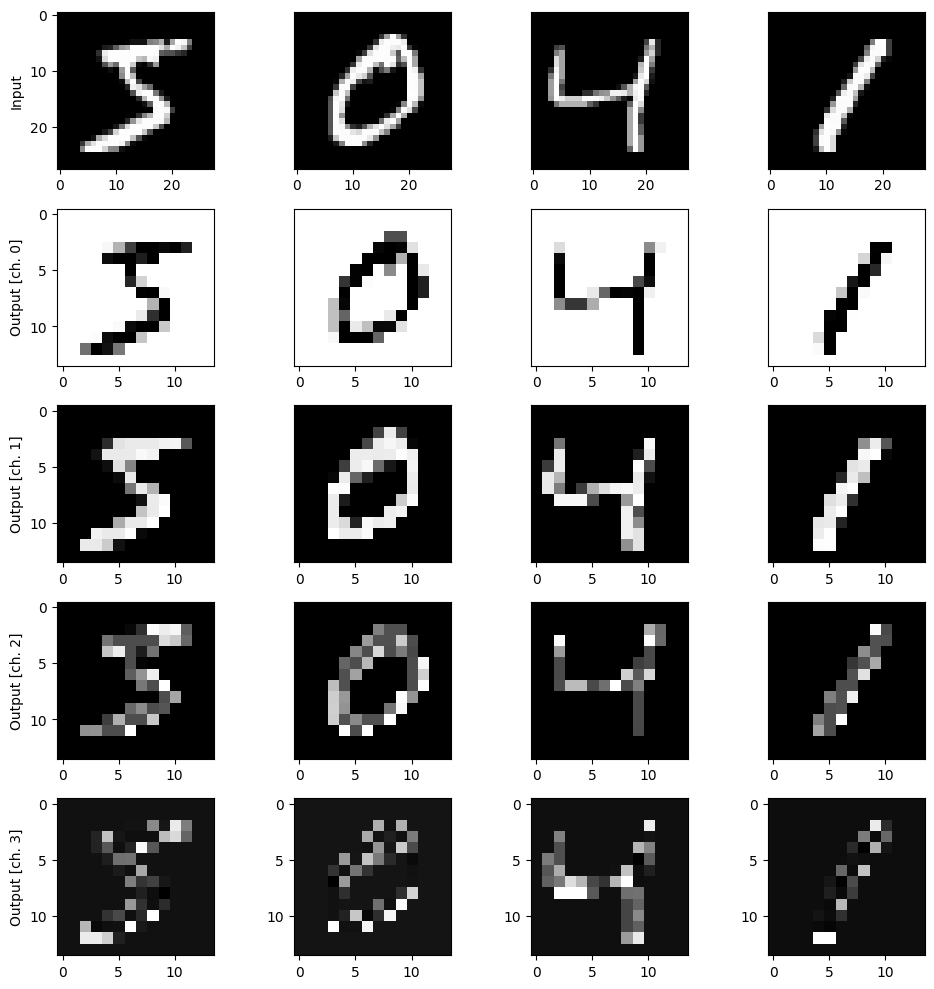

In [8]:
n_samples = 4  # Number of sample images to display
n_channels = 4  # Number of output channels from the quantum convolution
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))  # Create a grid of subplots

for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")  # Label the first row as "Input"
    if k != 0:
        axes[0, k].yaxis.set_visible(False)  # Hide y-axis labels for subsequent input images
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")  # Display the input image in grayscale
    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

#Defining Classical Model for Classification

This cell defines a classical Keras model for image classification. The model consists of a flatten layer to convert the multi-dimensional output of the quantum convolution into a one-dimensional vector, followed by a dense layer with softmax activation for classification.

In [9]:
# Define a classical model for classification
def MyModel():
    """Defines a simple Keras model for classification."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),  # Flatten the input data
        keras.layers.Dense(10, activation="softmax")  # Dense layer with softmax activation for classification
    ])
    model.compile(
        optimizer='adam',  # Use the Adam optimizer
        loss="sparse_categorical_crossentropy",  # Use cross-entropy loss for multi-class classification
        metrics=["accuracy"]  # Track accuracy as a metric
    )
    return model

#Training Classical Model on Quantum Preprocessed Data

This cell trains the classical Keras model on the quantum preprocessed training images and evaluates its performance on the quantum preprocessed test images.

In [10]:
# Train the classical model on quantum preprocessed data
q_model = MyModel()  # Initialize the model
q_history = q_model.fit(
    q_train_images,  # Train on quantum preprocessed images
    train_labels,
    validation_data=(q_test_images, test_labels),  # Validate on quantum preprocessed test images
    batch_size=4,
    epochs=n_epochs,
    verbose=2
)

Epoch 1/10
13/13 - 3s - 253ms/step - accuracy: 0.0600 - loss: 2.6527 - val_accuracy: 0.1667 - val_loss: 2.3561
Epoch 2/10
13/13 - 2s - 123ms/step - accuracy: 0.4600 - loss: 1.8954 - val_accuracy: 0.1333 - val_loss: 2.1777
Epoch 3/10
13/13 - 1s - 49ms/step - accuracy: 0.6400 - loss: 1.6044 - val_accuracy: 0.2667 - val_loss: 1.9878
Epoch 4/10
13/13 - 1s - 44ms/step - accuracy: 0.7800 - loss: 1.3074 - val_accuracy: 0.3667 - val_loss: 1.8441
Epoch 5/10
13/13 - 1s - 42ms/step - accuracy: 0.8600 - loss: 1.0864 - val_accuracy: 0.5000 - val_loss: 1.7313
Epoch 6/10
13/13 - 0s - 20ms/step - accuracy: 0.9000 - loss: 0.9089 - val_accuracy: 0.5333 - val_loss: 1.6394
Epoch 7/10
13/13 - 0s - 12ms/step - accuracy: 0.9200 - loss: 0.7677 - val_accuracy: 0.5667 - val_loss: 1.5585
Epoch 8/10
13/13 - 0s - 26ms/step - accuracy: 0.9800 - loss: 0.6543 - val_accuracy: 0.6333 - val_loss: 1.4900
Epoch 9/10
13/13 - 0s - 19ms/step - accuracy: 0.9800 - loss: 0.5612 - val_accuracy: 0.6333 - val_loss: 1.4335
Epoch 10

#Training Classical Model on Original MNIST Data

This cell trains a classical model on the original MNIST images without quantum preprocessing. This serves as a baseline for comparison with the quantum-enhanced model.

In [11]:
# Train a classical model on the original MNIST images for comparison
c_model = MyModel()  # Initialize the model
c_history = c_model.fit(
    train_images,  # Train on original MNIST images
    train_labels,
    validation_data=(test_images, test_labels),  # Validate on original MNIST test images
    batch_size=4,
    epochs=n_epochs,
    verbose=2
)

Epoch 1/10
13/13 - 2s - 152ms/step - accuracy: 0.0800 - loss: 2.4391 - val_accuracy: 0.0333 - val_loss: 2.4060
Epoch 2/10
13/13 - 0s - 9ms/step - accuracy: 0.3200 - loss: 1.9994 - val_accuracy: 0.1000 - val_loss: 2.2052
Epoch 3/10
13/13 - 0s - 12ms/step - accuracy: 0.6600 - loss: 1.6932 - val_accuracy: 0.3333 - val_loss: 2.0372
Epoch 4/10
13/13 - 0s - 12ms/step - accuracy: 0.7600 - loss: 1.4447 - val_accuracy: 0.4000 - val_loss: 1.8965
Epoch 5/10
13/13 - 0s - 17ms/step - accuracy: 0.9200 - loss: 1.2400 - val_accuracy: 0.4000 - val_loss: 1.7817
Epoch 6/10
13/13 - 0s - 18ms/step - accuracy: 0.9200 - loss: 1.0718 - val_accuracy: 0.4333 - val_loss: 1.6893
Epoch 7/10
13/13 - 0s - 16ms/step - accuracy: 0.9400 - loss: 0.9335 - val_accuracy: 0.5667 - val_loss: 1.6140
Epoch 8/10
13/13 - 0s - 12ms/step - accuracy: 0.9400 - loss: 0.8190 - val_accuracy: 0.6000 - val_loss: 1.5516
Epoch 9/10
13/13 - 0s - 11ms/step - accuracy: 0.9800 - loss: 0.7234 - val_accuracy: 0.6000 - val_loss: 1.4991
Epoch 10/1

#Plotting the Results

This cell plots the validation accuracy and validation loss for both models (with and without the quantum layer) to visualize their performance over the training epochs. This allows you to compare the impact of the quantum convolution layer on the classification task.

<ipython-input-12-b7ccebabdf02>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


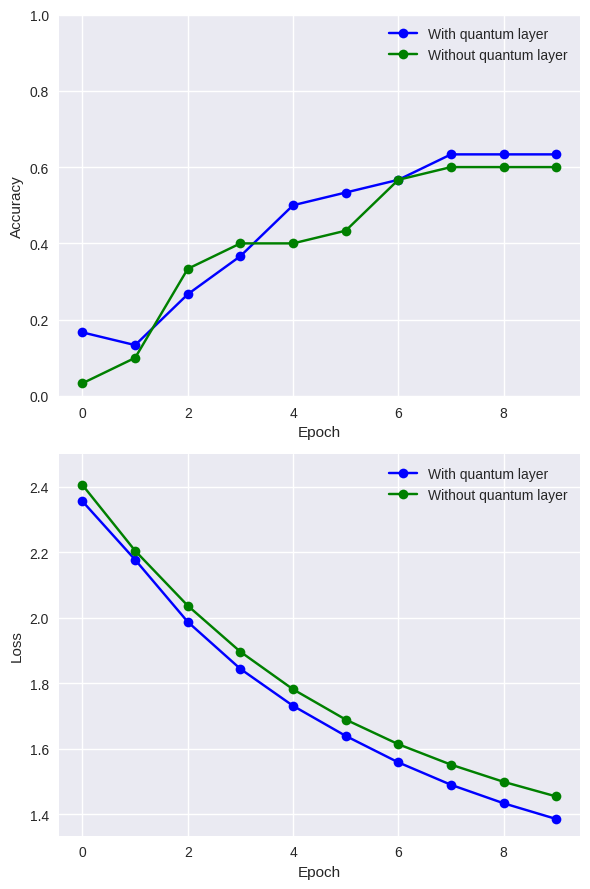

In [12]:
# Plot the results
plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

# Plot validation accuracy
ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

# Plot validation loss
ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

By comparing the performance of the two models, one can investigate whether the quantum convolution layer provides any advantage in terms of classification accuracy or learning efficiency. This approach explores the potential of combining quantum and classical machine learning techniques for image processing tasks.

##References
[1] Henderson, M., Shakya, S., Pradhan, S., & Cook, T. (2019). Quanvolutional Neural Networks: Powering Image Recognition with Quantum Circuits. ArXiv. /abs/1904.04767